In [31]:
from DataPreprocessing.python.Data import *

import pandas as pd
import numpy as np


## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# This is new, it will allow us to interact with
# 3d plots in the notebook
from mpl_toolkits.mplot3d import Axes3D


## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

In [32]:
rootData = Data("/Users/czkaiweb/Research/ErdosBootCamp/Project/ProjectData/Root_Insurance_data.csv")
rootData.loadData()
rootData.factorizeData()
rootData.splitData(fraction=[0.5,0.3,0.2],random_seed=42)
data_train = rootData.getTrainDataCopy()
data_validation = rootData.getValidationDataCopy()
data_test  = rootData.getTestDataCopy()

In [33]:
from xgboost import XGBRegressor

In [34]:
X_train = data_train.iloc[:, 0:4].values
y_train = data_train.iloc[:, -1].values

X_validation = data_validation.iloc[:, 0:4].values
y_validation = data_validation.iloc[:, -1].values

X_test = data_test.iloc[:, 0:4].values
y_test = data_test.iloc[:, -1].values

In [35]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_validation = sc.transform(X_validation)
X_test = sc.transform(X_test)

In [59]:
model = XGBRegressor(use_label_encoder=False)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', use_label_encoder=False,
             validate_parameters=1, verbosity=None)

In [37]:
from sklearn.metrics import accuracy_score

In [38]:
y_vpred = model.predict(X_validation)

In [60]:
import sklearn
#from sklearn.model_selection import cross_validation
from sklearn.model_selection import GridSearchCV

In [90]:

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.001,.002,.004,.008,.01, 0.02, .04, .08, 0.1], #so called `eta` value
              'max_depth': [3, 4, 5],
              'min_child_weight': [2, 3, 4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [200]}

clf = GridSearchCV(model, parameters, n_jobs=5, 
                   scoring='roc_auc',
                   verbose=2, refit=True)


In [92]:
clf.fit(X_train,y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[22:08:04] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[22:08:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs=12,
                                    num_parallel_tree...
                                    tree_method='exact',
                                    use_label_encoder=False,
                                    validate_parameters=1, verbosity=None),
             n_jobs=5,
             param_grid={'colsample_bytree': [0.7],
                         'learning_r

In [93]:
y_vpred = clf.predict(X_validation)

In [94]:
y_vpred.max()
print(clf.best_score_)
print(clf.best_params_)

0.7234774155538647
{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 200, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


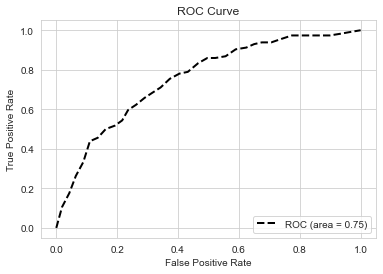

In [95]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_validation, y_vpred, pos_label=1)
roc_auc = auc(fpr, tpr)
 
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
 
plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [74]:
def getReward(regressor, threshold, Xs, ys):
    reward = 0
    for index,X in enumerate(Xs):
        if regressor.predict(X.reshape(1,-1)) > threshold and ys[index] == 1 :
            reward += 130
        elif regressor.predict(X.reshape(1,-1)) > threshold and ys[index] == 0 :
            reward += -10
    return reward
            

In [96]:
reward_buffer = []
for threshold in thresholds:
    reward = getReward(clf,threshold,X_validation,y_validation)
    reward_buffer.append(reward)
    
reward_buffer

[0,
 0,
 1300,
 2010,
 3010,
 3710,
 4970,
 4870,
 5160,
 5000,
 5060,
 5570,
 5600,
 5730,
 5760,
 5780,
 6010,
 5960,
 5710,
 5890,
 5860,
 5500,
 5160,
 5220,
 4870,
 4770,
 4550,
 4120,
 3920,
 3700,
 3160,
 2680,
 2350,
 1970,
 1610,
 1300]

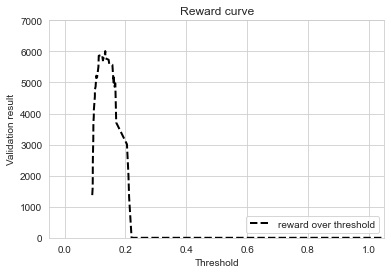

In [97]:
plt.plot(thresholds, reward_buffer, 'k--', label='reward over threshold', lw=2)
 
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 7000])
plt.xlabel('Threshold')
plt.ylabel('Validation result')
plt.title('Reward curve')
plt.legend(loc="lower right")
plt.show()

In [98]:
i_best_threshold = reward_buffer.index(max(reward_buffer))
best_threshold  = thresholds[i_best_threshold]
print("best_threshold = {}".format(best_threshold))

best_threshold = 0.1337425857782364


In [99]:
reward = getReward(clf,best_threshold,X_test,y_test)
print("reward = {}".format(reward))
reward_naive = getReward(clf,0,X_test,y_test)
print("naive reward = {}".format(reward_naive))

reward = 16660
naive reward = 5320
